# Imports

In [1]:
import streamlit
# import plotly.express as px

import sqlite3 as db
import pandas as pd
import os
import json
import random
import re

import numpy as np
from typing import Optional, Dict, Sequence
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import seaborn as sns

%matplotlib inline
import matplotlib, matplotlib.pyplot as plt
plt.ion()

# from IPython.display import display 

import warnings
warnings.filterwarnings("ignore")

# Data

In [2]:
# Leer todos los CSV que hemos descomprimido
def read_csvs():
   

    datasets = [ 'admissiondrug', 'admissionDx', 'allergy', 'apacheApsVar', 'apachePatientResult', 'apachePredVar', 'carePlanCareProvider', 'carePlanEOL', 'carePlanGeneral',
                 'carePlanGoal', 'carePlanInfectiousDisease', 'customLab', 'diagnosis', 'hospital', 'infusiondrug', 'intakeOutput', 'lab', 'medication', 'microLab', 'note',
                 'nurseAssessment', 'nurseCare', 'nurseCharting', 'pastHistory', 'patient', 'physicalExam', 'respiratoryCare', 'respiratoryCharting', 'treatment', 'vitalAperiodic',
                 'vitalPeriodic']

    dfs = {}

    for ds_name in datasets:
        dfs[ds_name] = pd.read_csv('../db/csv_clean/' + ds_name + '.csv')
    
    return dfs

dfs = read_csvs()

In [3]:
dfs.keys()

dict_keys(['admissiondrug', 'admissionDx', 'allergy', 'apacheApsVar', 'apachePatientResult', 'apachePredVar', 'carePlanCareProvider', 'carePlanEOL', 'carePlanGeneral', 'carePlanGoal', 'carePlanInfectiousDisease', 'customLab', 'diagnosis', 'hospital', 'infusiondrug', 'intakeOutput', 'lab', 'medication', 'microLab', 'note', 'nurseAssessment', 'nurseCare', 'nurseCharting', 'pastHistory', 'patient', 'physicalExam', 'respiratoryCare', 'respiratoryCharting', 'treatment', 'vitalAperiodic', 'vitalPeriodic'])

In [4]:
for keys in dfs.keys():
    print(f"###### Processing {keys}")
    print(dfs[keys].info())

###### Processing admissiondrug
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   patientunitstayid  551 non-null    int64
 1   aspirin            551 non-null    bool 
 2   lisinopril         551 non-null    bool 
 3   lasix              551 non-null    bool 
dtypes: bool(3), int64(1)
memory usage: 6.0 KB
None
###### Processing admissionDx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patientunitstayid      2221 non-null   int64
 1   OffSet_Cardiovascular  2221 non-null   int64
 2   OffSet_Respiratory     2221 non-null   int64
 3   OffSet_Neurologic      2221 non-null   int64
dtypes: int64(4)
memory usage: 69.5 KB
None
###### Processing allergy
<class 'pandas.core.frame.Data

Aunque el dataset original fue limpiado a conciencia, todavía se pueden apreciar muchas tablas interesantes para sacar información. Son tantas <br>
las posibilidades de plots que parecen ilimitadas, así que de manera intuitiva dado el caso de uso intentaré limitar el alcance de la visualización al <br> máximo intentando centrarme en lo más importante. Es posible que durante el proceso me deje algún plot interesante aunque intentaré evitarlo en la medida de lo posible.

## Patient

Como hemos visto durante el proceso de limpieza, `patient` es una de las tablas más interesantes.

In [5]:
dfs['patient'].head()

,patientunitstayid,gender,age,ethnicity,hospitalid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,unitvisitnumber,admissionweight,unitdischargeoffset,avg_unit_stay,avg_hospital_stay,admission_bmi
0,141764,Famale,87,Caucasian,59,NaN,157.5,-2258,Emergency Department,366,2,67.6,344,0,0,-1.000000
1,141765,Famale,87,Caucasian,59,"rhythm disturbance (atrial, supraventricular)",157.5,-8,Emergency Department,2616,1,46.5,2250,344,366,3.387097
2,143870,Male,76,Caucasian,68,"endarterectomy, carotid",167.0,-1,Operating Room,1218,1,77.5,793,0,0,2.154839
3,144815,Famale,34,Caucasian,56,"overdose, other toxin, poison or drug",172.7,-23,Emergency Department,1138,1,60.3,1121,0,0,2.864013
4,145427,Male,61,Caucasian,68,"gi perforation/rupture, surgery for",177.8,-10,Emergency Department,5263,1,91.7,1369,0,0,1.938931


In [6]:
dfs['patient'].columns

Index(['patientunitstayid', 'gender', 'age', 'ethnicity', 'hospitalid',
       'apacheadmissiondx', 'admissionheight', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeoffset', 'unitvisitnumber',
       'admissionweight', 'unitdischargeoffset', 'avg_unit_stay',
       'avg_hospital_stay', 'admission_bmi'],
      dtype='object')

### Plots

#### Utils

In [7]:
def numeric_age(s: pd.Series) -> pd.Series:
    s = s.astype(str)
    older_mask = s.str.contains(">")
    out = pd.to_numeric(s.str.extract(r"(\d+)")[0], errors="coerce")
    out[older_mask] = np.where(out[older_mask].notna(), out[older_mask], 90)
    return out

def preprocess_patient(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "age" in df.columns:
        df["age_years"] = numeric_age(df["age"])
    else:
        df["age_years"] = np.nan

    if "unitdischargeoffset" in df.columns:
        df["icu_los_days"] = pd.to_numeric(df["unitdischargeoffset"], errors="coerce") / (60*24)
    else:
        df["icu_los_days"] = np.nan

    df = df[(df["icu_los_days"].between(0,120)) | df["icu_los_days"].isna()]
    df = df[(df["age_years"].between(0,110)) | df["age_years"].isna()]

    for c in ["gender","ethnicity","hospitaladmitsource","apacheadmissiondx"]:
        if c in df.columns:
            df[c] = df[c].astype("string").str.strip().str.title()
    for c in ["patientunitstayid","hospitalid"]:
        if c in df.columns:
            df[c] = df[c].astype("Int64").astype("string")
    return df

def top_n_index(s: pd.Series, n: int) -> pd.Index:
    return s.value_counts(dropna=False).head(n).index

#### Estancia media UCI (Días)

In [8]:
def plot_hist_los(df: pd.DataFrame, bins: int = 50, logy: bool = False, ax=None): 
    created = False 
    if ax is None: 
        fig, ax = plt.subplots(figsize=(8,5))
        created = True 
    else: 
        fig = ax.figure 
        x = df["icu_los_days"].dropna() 
        ax.hist(x, bins=bins, edgecolor="black") 
        ax.set_title("Histograma de estancia en UCI (días)") 
        ax.set_xlabel("Estancia UCI (días)") 
        ax.set_ylabel("Frecuencia") 
        ax.grid(True, linestyle="--", alpha=0.4) 
        if logy: 
            ax.set_yscale("log")
            
        if created: 
            fig.tight_layout() 
    return fig, ax

#### Estancia media UCI (Género)

In [9]:
def plot_box_by_gender(df: pd.DataFrame, ax=None):
    if "gender" not in df.columns:
        raise ValueError("Falta la columna 'gender'.")
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
        created = True
    else:
        fig = ax.figure

    genders = list(df["gender"].dropna().unique())
    data = [df.loc[df["gender"]==g, "icu_los_days"].dropna() for g in genders]
    ax.boxplot(data, labels=genders, showfliers=True)
    ax.set_title("Estancia en UCI por género")
    ax.set_xlabel("Género")
    ax.set_ylabel("Estancia UCI (días)")
    ax.grid(True, linestyle="--", alpha=0.4)
    if created: fig.tight_layout()
    return fig, ax

#### Admisión en el hospital

In [10]:
def plot_bar_admit_source(df: pd.DataFrame, top_n: int = 8, ax=None):
    if "hospitaladmitsource" not in df.columns:
        raise ValueError("Falta la columna 'hospitaladmitsource'.")
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
        created = True
    else:
        fig = ax.figure

    counts = df["hospitaladmitsource"].fillna("Desconocido").value_counts().head(top_n)
    ax.bar(counts.index, counts.values, edgecolor="black")
    ax.set_title(f"Fuente de admisión hospitalaria (top {top_n})")
    ax.set_xlabel("Fuente de admisión")
    ax.set_ylabel("Pacientes")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right")
    if created: fig.tight_layout()
    return fig, ax

#### Estancia media UCI (Edad)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scatter_age_los(df: pd.DataFrame,
                         max_points: int = 50000,
                         ax=None,
                         trendline: bool = True,
                         method: str = "linear",      # "linear" | "lowess"
                         smooth_frac: float = 0.25,
                         colorize_bins: bool = True,
                         add_kde: bool = True,        # <--- NUEVO: densidad 2D
                         kde_levels: int = 10,
                         kde_fill: bool = True,
                         kde_alpha: float = 0.25):
    """
    Dispersión Edad vs Estancia UCI con:
      - Colores por tramos de edad: <30, 30–60, 60–80, 80+ (si colorize_bins=True)
      - Línea de tendencia (linear/lowess) opcional
      - Contornos/heatmap de densidad 2D (sns.kdeplot) opcional
    """
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
        created = True
    else:
        fig = ax.figure

    tmp = df[["age_years", "icu_los_days"]].dropna()
    if len(tmp) > max_points:
        tmp = tmp.sample(max_points, random_state=42)

    # --- KDE 2D detrás de los puntos ---
    if add_kde and len(tmp) >= 10:  # requiere algo de muestra
        try:
            sns.kdeplot(
                x=tmp["age_years"], y=tmp["icu_los_days"],
                ax=ax,
                levels=kde_levels,
                fill=kde_fill,
                alpha=kde_alpha,
                thresh=0,
                bw_method="scott",
                cmap="Greys",
                linewidths=1,
                zorder=0
            )
        except Exception:
            pass

    # --- Puntos ---
    if colorize_bins:
        bins = [-np.inf, 30, 60, 80, np.inf]
        labels = ["<30", "30–60", "60–80", "80+"]
        tmp = tmp.copy()
        tmp["age_bin"] = pd.cut(tmp["age_years"], bins=bins, labels=labels, right=False, include_lowest=True)
        for label, sub in tmp.groupby("age_bin", sort=False):
            if len(sub) == 0: 
                continue
            ax.scatter(sub["age_years"], sub["icu_los_days"], alpha=0.5, s=20, label=str(label), zorder=1)
        ax.legend(title="Edad (años)", loc="best")
    else:
        ax.scatter(tmp["age_years"], tmp["icu_los_days"], alpha=0.5, s=20, zorder=1)

    # --- Tendencia ---
    if trendline and len(tmp) >= 2:
        x = tmp["age_years"].to_numpy()
        y = tmp["icu_los_days"].to_numpy()
        if method == "lowess":
            try:
                from statsmodels.nonparametric.smoothers_lowess import lowess
                sm = lowess(y, x, frac=smooth_frac, it=0, return_sorted=True)
                ax.plot(sm[:, 0], sm[:, 1], linewidth=2, label="Tendencia (LOWESS)", zorder=2)
            except Exception:
                p = np.polyfit(x, y, 1)
                xx = np.linspace(x.min(), x.max(), 200)
                ax.plot(xx, np.polyval(p, xx), linewidth=2, label="Tendencia (lineal)", zorder=2)
                ax.legend(loc="best")
        elif method == "linear":
            p = np.polyfit(x, y, 1)
            xx = np.linspace(x.min(), x.max(), 200)
            ax.plot(xx, np.polyval(p, xx), linewidth=2, label="Tendencia (lineal)", zorder=2)
            ax.legend(loc="best")

    ax.set_title("Edad vs estancia en UCI")
    ax.set_xlabel("Edad (años)")
    ax.set_ylabel("Estancia UCI (días)")
    ax.grid(True, linestyle="--", alpha=0.4)

    if created:
        fig.tight_layout()
    return fig, ax

#### Estancia media UCI (diagnosticos)

In [44]:
def plot_bar_mean_by_dx(df: pd.DataFrame, top_n: int = 8, ax=None):
    if "apacheadmissiondx" not in df.columns:
        raise ValueError("Falta la columna 'apacheadmissiondx'.")
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
        created = True
    else:
        fig = ax.figure

    top = top_n_index(df["apacheadmissiondx"], n=top_n)
    tmp = df[df["apacheadmissiondx"].isin(top)].copy()
    med = (tmp.groupby("apacheadmissiondx")["icu_los_days"]
              .mean().sort_values(ascending=True))
    ax.barh(med.index, med.values, edgecolor="black")
    ax.set_title(f"Estancia media por diagnóstico (top {top_n})")
    ax.set_xlabel("Estancia media (días)")
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)    
    if created: fig.tight_layout()
        
    return fig, ax

#### Estancia media UCI

In [45]:
def plot_bar_mean_by_hospital(df: pd.DataFrame, top_n: int = 8, ax=None):
    if "hospitalid" not in df.columns:
        raise ValueError("Falta la columna 'hospitalid'.")
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
        created = True
    else:
        fig = ax.figure

    top = top_n_index(df["hospitalid"], n=top_n)
    tmp = df[df["hospitalid"].isin(top)].copy()
    med = (tmp.groupby("hospitalid")["icu_los_days"]
              .mean().sort_values(ascending=False))
    ax.bar(med.index.astype(str), med.values, edgecolor="black")
    ax.set_title(f"Estancia media por hospital (top {top_n})")
    ax.set_xlabel("Hospital ID")
    ax.set_ylabel("Estancia media (días)")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    if created: fig.tight_layout()
    return fig, ax

#### Ethnicity

In [46]:
def plot_violin_los_by_ethnicity(df: pd.DataFrame,
                                 top_n: int = 5,
                                 min_count: int = 20,
                                 ax=None,
                                 cmap: str = "tab20",
                                 colors: Optional[Dict[str, str]] = None):
    """
    Violinplot de icu_los_days por etnia (top_n por volumen).
    Filtra etnias con menos de min_count para evitar violines degenerados.
    
    Parámetros extra:
    - cmap: nombre de colormap de Matplotlib (p.ej. 'tab10', 'tab20', 'Set3', etc.)
    - colors: dict opcional {etnia: color} para coloreado fijo y reproducible.
    """
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        created = True
    else:
        fig = ax.figure

    tmp = df[["ethnicity", "icu_los_days"]].copy()
    tmp["ethnicity"] = tmp["ethnicity"].fillna("Desconocido").astype(str).str.title()
    tmp = tmp.dropna(subset=["icu_los_days"])

    top_eth = tmp["ethnicity"].value_counts().head(top_n).index
    tmp = tmp[tmp["ethnicity"].isin(top_eth)]

    counts = tmp["ethnicity"].value_counts()
    valid_eth = counts[counts >= min_count].index
    tmp = tmp[tmp["ethnicity"].isin(valid_eth)]

    if tmp.empty:
        ax.text(0.5, 0.5, "Sin datos suficientes tras el filtrado",
                ha="center", va="center", transform=ax.transAxes)
        ax.set_axis_off()
        return fig, ax

    order = (tmp.groupby("ethnicity")["icu_los_days"]
                .median().sort_values(ascending=False).index.tolist())

    data = [tmp.loc[tmp["ethnicity"] == e, "icu_los_days"].values for e in order]
    parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)

    if colors is None:
        cmap_obj = plt.get_cmap(cmap)
        palette = [cmap_obj(i % cmap_obj.N) for i in range(len(order))]
        color_map = {e: palette[i] for i, e in enumerate(order)}
    else:
        cmap_obj = plt.get_cmap(cmap)
        palette = [cmap_obj(i % cmap_obj.N) for i in range(len(order))]
        color_map = {e: colors.get(e, palette[i]) for i, e in enumerate(order)}

    for pc, e in zip(parts['bodies'], order):
        pc.set_facecolor(color_map[e])
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    med = [np.median(d) if len(d) else np.nan for d in data]
    ax.scatter(range(1, len(data)+1), med, marker="o", zorder=3, c=[color_map[e] for e in order], edgecolor="black")

    ax.set_xticks(range(1, len(order)+1))
    ax.set_xticklabels(order, rotation=25, ha="right")
    ax.set_title("Estancia UCI por etnia")
    ax.set_xlabel("Etnia")
    ax.set_ylabel("Estancia UCI (días)")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    handles = [mpatches.Patch(facecolor=color_map[e], edgecolor="black", label=e) for e in order]
    ax.legend(handles=handles, title="Etnia", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    if created:
        fig.tight_layout()
    return fig, ax

#### Height

In [47]:
def plot_height_hist(df: pd.DataFrame,
                     ax=None,
                     bins: int = 40,
                     density: bool = False,
                     clip: tuple | None = (120, 210)):
    """
    Histograma 1D de la altura de admisión (cm) por grupos:
      <170, 170–180, ≥180
    con KDE (sns.kdeplot) superpuesta. La KDE se reescala a counts si density=False.
    """
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        created = True
    else:
        fig = ax.figure

    # Altura -> cm
    h = pd.to_numeric(df["admissionheight"], errors="coerce")
    height_cm = np.where(h > 3, h, h * 100.0)
    height_cm = pd.Series(height_cm, index=df.index).dropna()

    # Recorte opcional
    if clip is not None:
        lo, hi = clip
        height_cm = height_cm[(height_cm >= lo) & (height_cm <= hi)]

    if height_cm.empty:
        ax.text(0.5, 0.5, "Sin datos válidos", ha="center", va="center", transform=ax.transAxes)
        if created:
            fig.tight_layout()
        return fig, ax

    counts, edges = np.histogram(height_cm.values, bins=bins, density=density)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_widths = np.diff(edges)
    bin_width = float(bin_widths.mean())

    tmp = pd.DataFrame({"height_cm": height_cm})
    bins_groups = [-np.inf, 170, 180, np.inf]
    labels = ["<170", "170–180", "≥180"]
    tmp["height_group"] = pd.cut(tmp["height_cm"], bins=bins_groups, labels=labels, right=False)

    palette = {"<170": "#1f77b4", "170–180": "#ff7f0e", "≥180": "#2ca02c"}

    multiple = "stack" if not density else "layer"
    stat = "density" if density else "count"
    sns.histplot(
        data=tmp,
        x="height_cm",
        hue="height_group",
        bins=edges,
        multiple=multiple,
        stat=stat,
        edgecolor="black",
        alpha=0.8,
        palette=palette,
        ax=ax,
        legend=False,
    )

    kde_line = sns.kdeplot(
        height_cm.values,
        ax=ax,
        bw_method="scott",
        cut=0,            
        linewidth=2
    )

    if not density:
        line = ax.lines[-1]  
        y = line.get_ydata()
        y_counts = y * len(height_cm) * bin_width
        line.set_ydata(y_counts)

    present = [g for g in labels if g in tmp["height_group"].dropna().unique().tolist()]
    if present:
        handles = [Patch(facecolor=palette[g], edgecolor="black", label=g) for g in present]
        ax.legend(handles=handles, title="Grupo de altura (cm)", loc="best")

    ax.set_title("Distribución de altura de admisión (cm)")
    ax.set_xlabel("Altura (cm)")
    ax.set_ylabel("Densidad" if density else "Frecuencia")
    ax.grid(True, linestyle="--", alpha=0.35)

    if created:
        fig.tight_layout()
    return fig, ax

#### Zona UCI

In [48]:
def plot_pie_hospital_admit_source(df: pd.DataFrame,
                                   top_n: int = 5,
                                   ax=None,
                                   show_counts: bool = True,
                                   label_radius: float = 1.28,
                                   line_radius: float = 1.02,
                                   min_sep: float = 0.125,     
                                   clip_low: float = -0.125,   
                                   clip_high: float = 0.90,
                                   title_y: float = 1.06,
                                   top_adjust: float = 0.88):
    """
    Pie chart de pacientes por hospitaladmitsource con etiquetas fuera, flechas
    y *dodge vertical* para evitar solapamientos. Separa y ajusta etiquetas
    por lado (izq/der) manteniendo un espaciamiento mínimo 'min_sep'.
    """
    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))
        created = True
    else:
        fig = ax.figure

    s = df["hospitaladmitsource"].fillna("Desconocido").astype(str).str.title()
    counts = s.value_counts()
    if len(counts) > top_n:
        top = counts.head(top_n)
        otros = counts.iloc[top_n:].sum()
        counts = pd.concat([top, pd.Series({"Otros": otros})])

    labels = counts.index.to_list()
    vals = counts.values
    total = vals.sum()
    pcts = (100.0 * vals / total) if total > 0 else np.zeros_like(vals, dtype=float)

    wedges, _ = ax.pie(vals, startangle=90, counterclock=False, labels=None, autopct=None)
    ax.axis("equal")

    def _spread_on_side(items, min_sep, low, high):
        if not items:
            return
        items.sort(key=lambda d: d["y"])

        items[0]["y_adj"] = np.clip(items[0]["y"], low, high)
        for i in range(1, len(items)):
            yi = max(items[i]["y"], items[i-1]["y_adj"] + min_sep)
            items[i]["y_adj"] = yi
        over = items[-1]["y_adj"] - high
        if over > 0:
            items[-1]["y_adj"] = high
            for i in range(len(items)-2, -1, -1):
                yi = min(items[i]["y_adj"], items[i+1]["y_adj"] - min_sep)
                items[i]["y_adj"] = yi

        for it in items:
            it["y_adj"] = float(np.clip(it["y_adj"], low, high))

    left_items, right_items = [], []
    for wedge, lab, pct, n in zip(wedges, labels, pcts, vals):
        theta = 0.5 * (wedge.theta1 + wedge.theta2)
        rad = np.deg2rad(theta)
        x = float(np.cos(rad))
        y = float(np.sin(rad))
        item = {
            "theta": theta, "x": x, "y": y, "lab": lab, "pct": pct, "n": int(n)
        }
        (right_items if x >= 0 else left_items).append(item)

    _spread_on_side(right_items, min_sep=min_sep, low=clip_low, high=clip_high)
    _spread_on_side(left_items,  min_sep=min_sep, low=clip_low, high=clip_high)

    for items, side in ((right_items, "right"), (left_items, "left")):
        for it in items:
            x, y, y_adj = it["x"], it["y"], it["y_adj"]
            xy = (line_radius * x, line_radius * y)
            tx = label_radius * (1 if side == "right" else -1)
            ty = label_radius * y_adj
            ha = "left" if side == "right" else "right"

            txt = f"{it['lab']}: {it['pct']:.1f}%"
            if show_counts:
                txt += f" (n={it['n']})"

            ax.annotate(
                txt,
                xy=xy, xytext=(tx, ty),
                ha=ha, va="center",
                textcoords="data",
                arrowprops=dict(
                    arrowstyle="-",
                    lw=1.2,
                    shrinkA=0, shrinkB=0,
                    connectionstyle=f"angle3,angleA=0,angleB={it['theta']}"
                ),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.85),
                zorder=1
            )

    ax.set_title(f"Máxima ocupación ({top_n})", y=title_y)
    if created:
        fig.subplots_adjust(top=top_adjust)
    return fig, ax

#### Mix

In [49]:
def plot_dashboard_3x3(df: pd.DataFrame):
    """Dibuja los 6 gráficos en un único figure 2x3 y lo devuelve."""
    fig, axs = plt.subplots(3, 3, figsize=(22, 15))  
    axs = np.asarray(axs)

    plot_hist_los(df, ax=axs[0,0])
    plot_box_by_gender(df, ax=axs[0,1])
    plot_bar_admit_source(df, ax=axs[0,2])

    plot_scatter_age_los(df, ax=axs[1,0])
    plot_bar_mean_by_dx(df, ax=axs[1,1])
    plot_bar_mean_by_hospital(df, ax=axs[1,2])

    plot_violin_los_by_ethnicity(df, ax=axs[2,0])
    plot_height_hist(df, ax=axs[2,1])
    plot_pie_hospital_admit_source(df, ax=axs[2,2])

    fig.tight_layout()
    return fig, axs

In [50]:
df_patient = preprocess_patient(dfs['patient'])
df_patient.head()

,patientunitstayid,gender,age,ethnicity,hospitalid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,unitvisitnumber,admissionweight,unitdischargeoffset,avg_unit_stay,avg_hospital_stay,admission_bmi,age_years,icu_los_days
0,141764,Famale,87,Caucasian,59,<NA>,157.5,-2258,Emergency Department,366,2,67.6,344,0,0,-1.000000,87,0.238889
1,141765,Famale,87,Caucasian,59,"Rhythm Disturbance (Atrial, Supraventricular)",157.5,-8,Emergency Department,2616,1,46.5,2250,344,366,3.387097,87,1.562500
2,143870,Male,76,Caucasian,68,"Endarterectomy, Carotid",167.0,-1,Operating Room,1218,1,77.5,793,0,0,2.154839,76,0.550694
3,144815,Famale,34,Caucasian,56,"Overdose, Other Toxin, Poison Or Drug",172.7,-23,Emergency Department,1138,1,60.3,1121,0,0,2.864013,34,0.778472
4,145427,Male,61,Caucasian,68,"Gi Perforation/Rupture, Surgery For",177.8,-10,Emergency Department,5263,1,91.7,1369,0,0,1.938931,61,0.950694


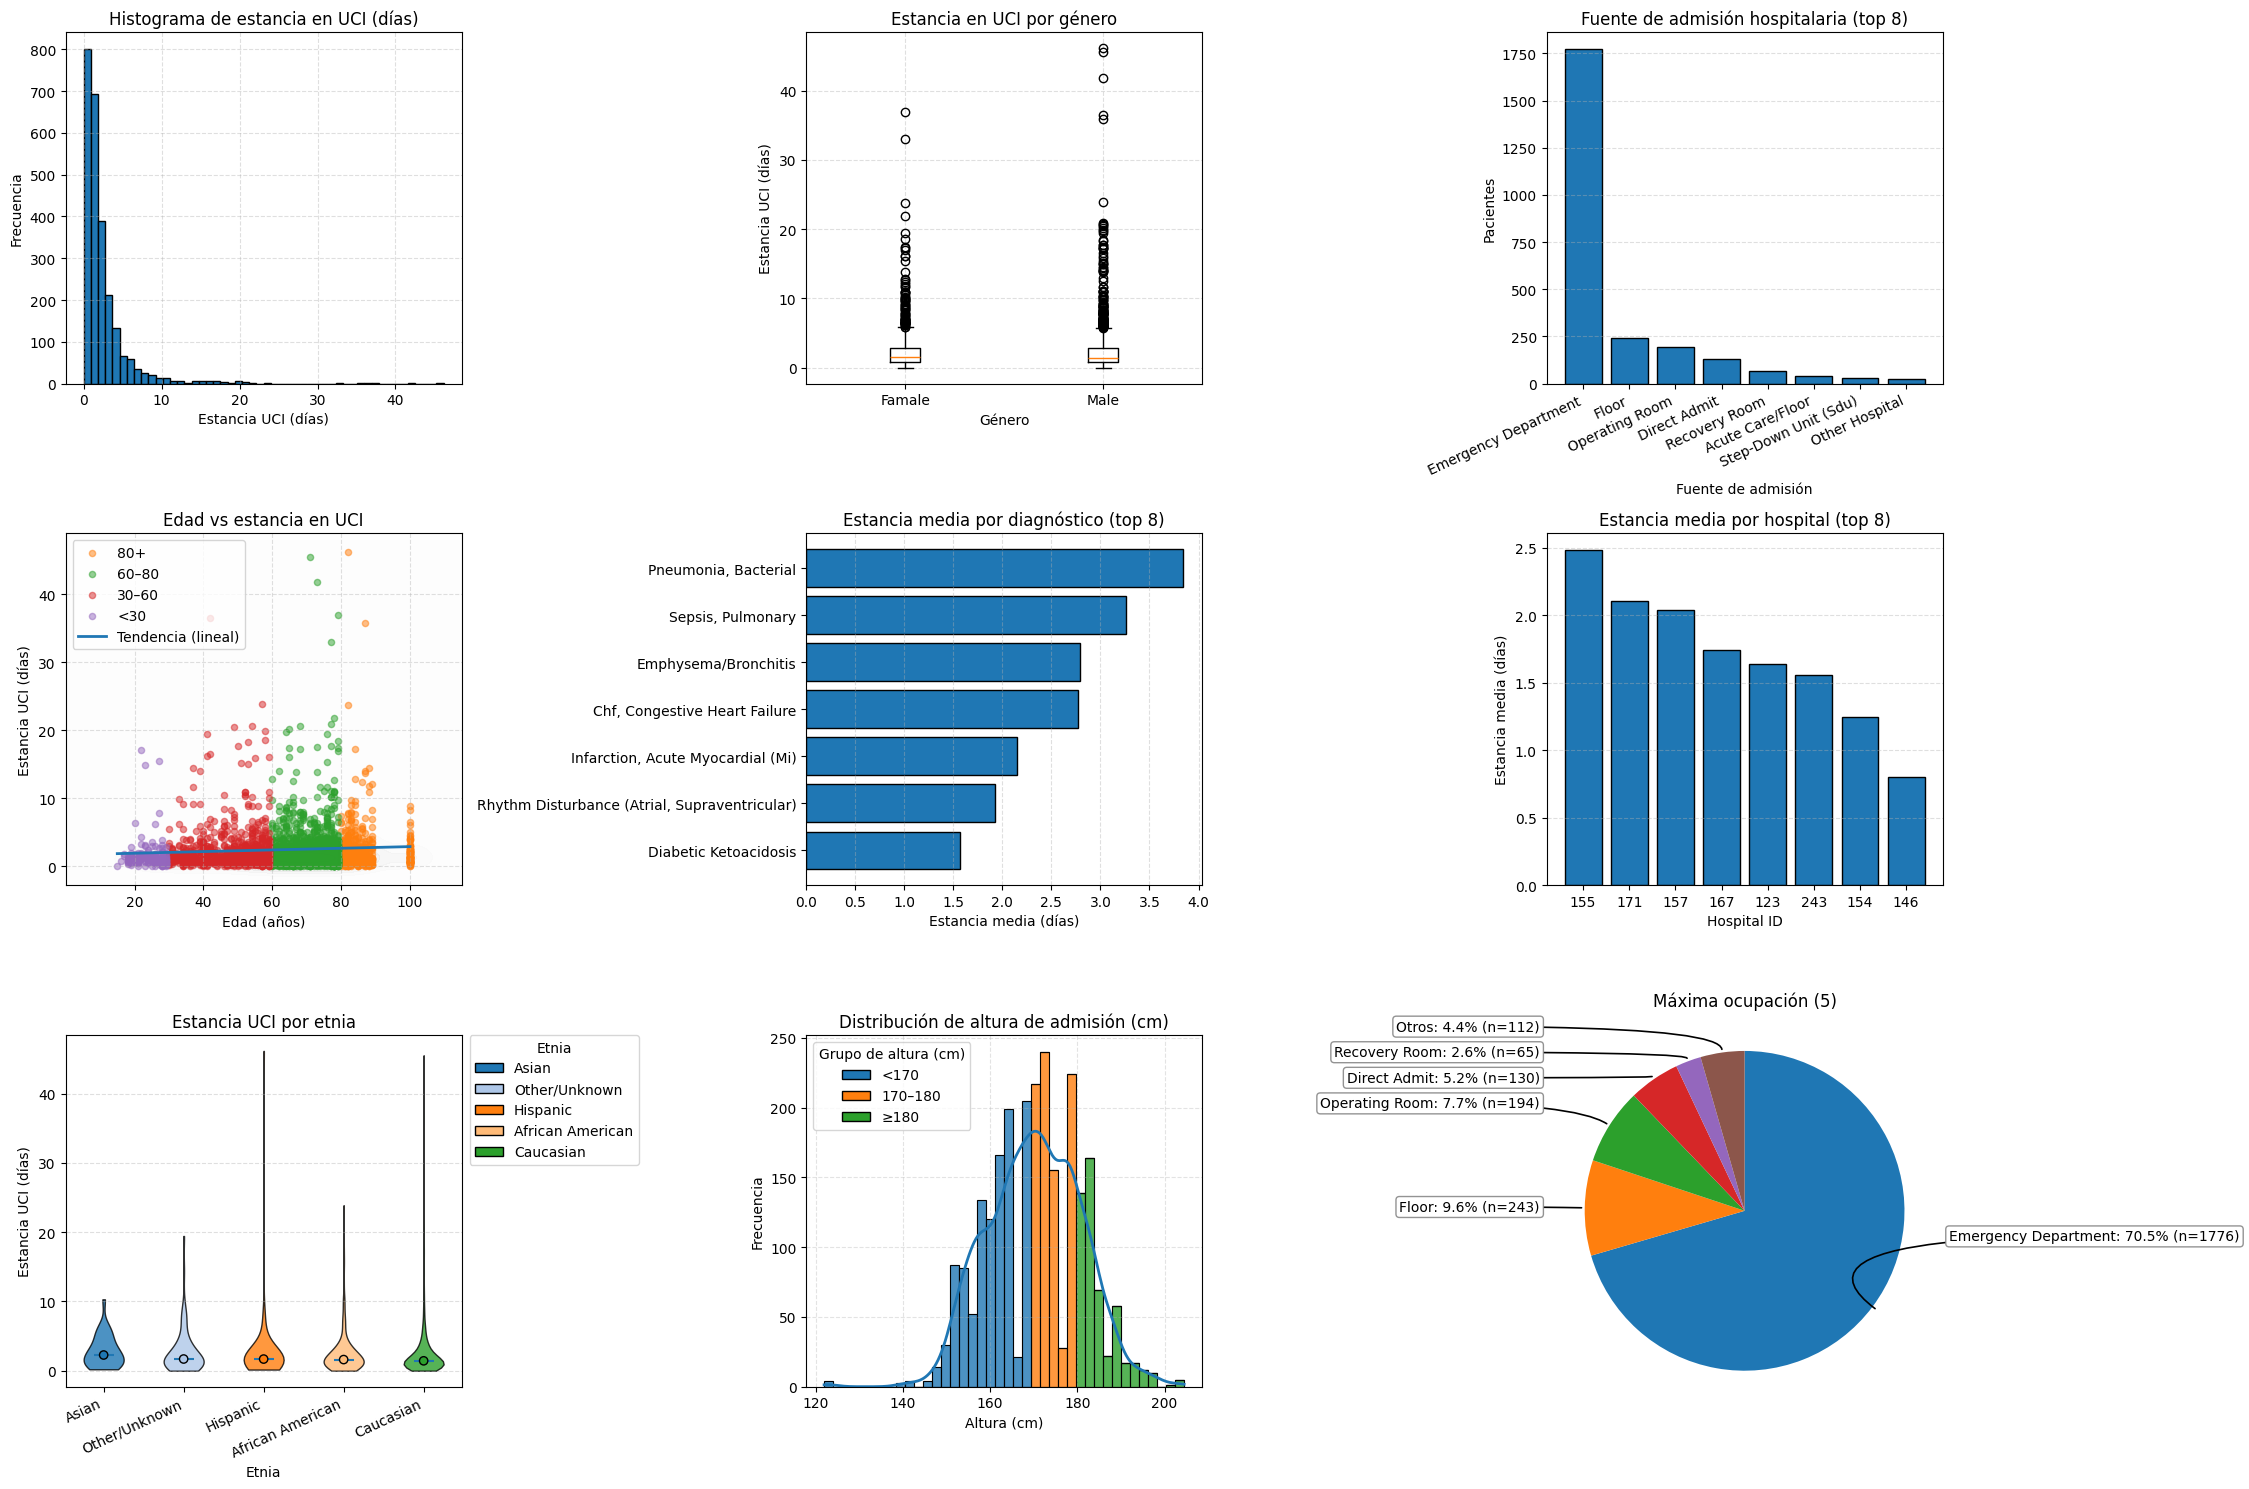

In [51]:
plot_dashboard_3x3(df_patient);

## Patient + Hospital

In [20]:
def merge_patient_with_region(df_patient: pd.DataFrame, hospital_df: pd.DataFrame) -> pd.DataFrame:
    hosp = hospital_df.copy()
    
    hosp.columns = hosp.columns.str.lower()
    region_col = next((c for c in ["region", "hospitalregion", "región"] if c in hosp.columns), None)
    if region_col is None:
        raise ValueError(
            f"No encontré columna 'region' en dfs['hospital']. "
            f"Columnas disponibles: {list(hosp.columns)}"
        )

    dfp = df_patient.copy()
    dfp["hospitalid"] = dfp["hospitalid"].astype(str)

    hosp = hosp[["hospitalid", region_col]].drop_duplicates()
    hosp["hospitalid"] = hosp["hospitalid"].astype(str)

    merged = dfp.merge(hosp, on="hospitalid", how="left")

    if region_col != "region":
        merged = merged.rename(columns={region_col: "region"})

    return merged

def plot_patients_by_region(df_patient_with_region: pd.DataFrame, top_n: int = None):
    if "region" not in df_patient_with_region.columns:
        raise ValueError("El DataFrame no tiene la columna 'region'. Ejecuta primero el merge.")

    counts = (
        df_patient_with_region["region"]
        .fillna("Desconocido")
        .value_counts()
    )
    if top_n is not None:
        counts = counts.head(top_n)

    counts = counts.sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.barh(counts.index.astype(str), counts.values, edgecolor="black")
    ax.set_title("Pacientes por región")
    ax.set_xlabel("Número de pacientes")
    ax.set_ylabel("Región")
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)

    for i, v in enumerate(counts.values):
        ax.text(v, i, f" {v}", va="center")

    fig.tight_layout()
    return fig, ax

In [21]:
df_patient_region = merge_patient_with_region(df_patient, dfs["hospital"])
df_patient_region.head()

,patientunitstayid,gender,age,ethnicity,hospitalid,apacheadmissiondx,admissionheight,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeoffset,unitvisitnumber,admissionweight,unitdischargeoffset,avg_unit_stay,avg_hospital_stay,admission_bmi,age_years,icu_los_days,region
0,141764,Famale,87,Caucasian,59,<NA>,157.5,-2258,Emergency Department,366,2,67.6,344,0,0,-1.000000,87,0.238889,Midwest
1,141765,Famale,87,Caucasian,59,"Rhythm Disturbance (Atrial, Supraventricular)",157.5,-8,Emergency Department,2616,1,46.5,2250,344,366,3.387097,87,1.562500,Midwest
2,143870,Male,76,Caucasian,68,"Endarterectomy, Carotid",167.0,-1,Operating Room,1218,1,77.5,793,0,0,2.154839,76,0.550694,Midwest
3,144815,Famale,34,Caucasian,56,"Overdose, Other Toxin, Poison Or Drug",172.7,-23,Emergency Department,1138,1,60.3,1121,0,0,2.864013,34,0.778472,Midwest
4,145427,Male,61,Caucasian,68,"Gi Perforation/Rupture, Surgery For",177.8,-10,Emergency Department,5263,1,91.7,1369,0,0,1.938931,61,0.950694,Midwest


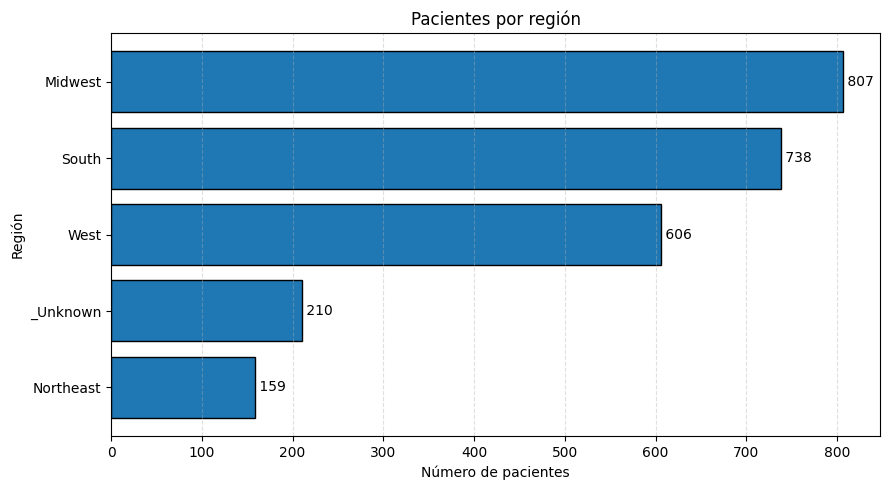

In [22]:
plot_patients_by_region(df_patient_region);